# **Important Libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **Prepare Data**

In [2]:
def prepare_data(data_dir):
    
    filepaths = []
    labels = []
    
    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            filepath = os.path.join(foldpath, file)
            filepaths.append(filepath)
            labels.append(fold)
    
    df = pd.DataFrame(data={'filepaths': filepaths, 'labels': labels})
    return df

In [3]:
train_dir = '/kaggle/input/animal-image-classification-dataset/Training Data/Training Data'
train = prepare_data(train_dir)
print(f'The shape of train data: {train.shape}')
train.head()

The shape of train data: (30000, 2)


,filepaths,labels
0,/kaggle/input/animal-image-classification-data...,Beetle
1,/kaggle/input/animal-image-classification-data...,Beetle
2,/kaggle/input/animal-image-classification-data...,Beetle
3,/kaggle/input/animal-image-classification-data...,Beetle
4,/kaggle/input/animal-image-classification-data...,Beetle


In [4]:
test_dir = '/kaggle/input/animal-image-classification-dataset/Testing Data/Testing Data'
test = prepare_data(test_dir)
print(f'The shape of train data: {test.shape}')
train.head()

The shape of train data: (2407, 2)


,filepaths,labels
0,/kaggle/input/animal-image-classification-data...,Beetle
1,/kaggle/input/animal-image-classification-data...,Beetle
2,/kaggle/input/animal-image-classification-data...,Beetle
3,/kaggle/input/animal-image-classification-data...,Beetle
4,/kaggle/input/animal-image-classification-data...,Beetle


In [5]:
valid_dir = '/kaggle/input/animal-image-classification-dataset/Validation Data/Validation Data'
validation = prepare_data(valid_dir)
print(f'The shape of train data: {validation.shape}')
train.head()

The shape of train data: (2000, 2)


,filepaths,labels
0,/kaggle/input/animal-image-classification-data...,Beetle
1,/kaggle/input/animal-image-classification-data...,Beetle
2,/kaggle/input/animal-image-classification-data...,Beetle
3,/kaggle/input/animal-image-classification-data...,Beetle
4,/kaggle/input/animal-image-classification-data...,Beetle


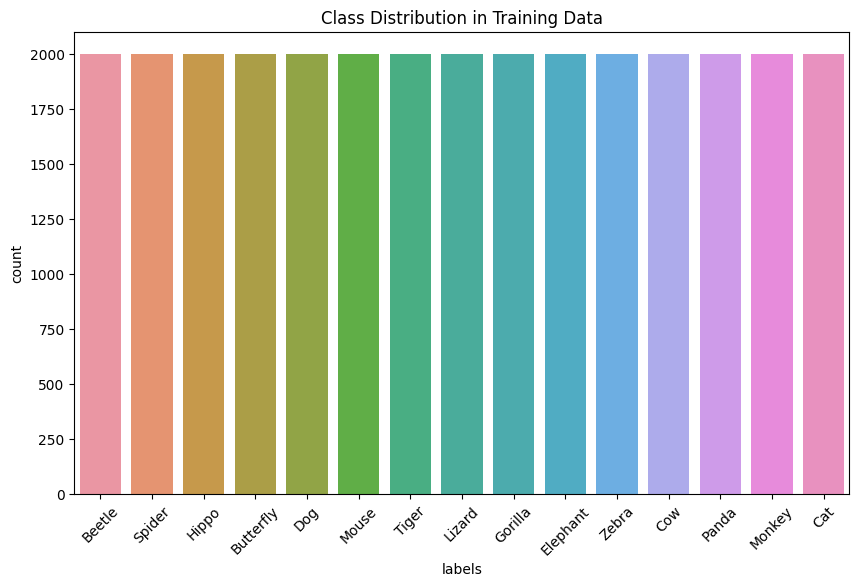

In [6]:
# Class Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=train, x='labels')
plt.title('Class Distribution in Training Data')
plt.xticks(rotation=45)
plt.show()

In [7]:
batch_size = 32
img_size = (224, 224)

train_genenator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_genenator = ImageDataGenerator(
    rescale=1./255               
)

train_gen = train_genenator.flow_from_dataframe( 
    train, 
    x_col= 'filepaths',
    y_col= 'labels', 
    target_size= img_size, 
    class_mode= 'categorical',
    color_mode= 'rgb',
    shuffle= True,
    batch_size= batch_size
)

valid_gen = test_genenator.flow_from_dataframe(
    validation, 
    x_col= 'filepaths', 
    y_col= 'labels', 
    target_size= img_size, 
    class_mode= 'categorical',
    color_mode= 'rgb', 
    shuffle= False, 
    batch_size= batch_size
)

test_gen = test_genenator.flow_from_dataframe(
    test,
    x_col= 'filepaths',
    y_col= 'labels',
    target_size= img_size, 
    class_mode= 'categorical',
    color_mode= 'rgb', 
    shuffle= False, 
    batch_size= batch_size
)

Found 30000 validated image filenames belonging to 15 classes.
Found 2000 validated image filenames belonging to 15 classes.
Found 2407 validated image filenames belonging to 15 classes.


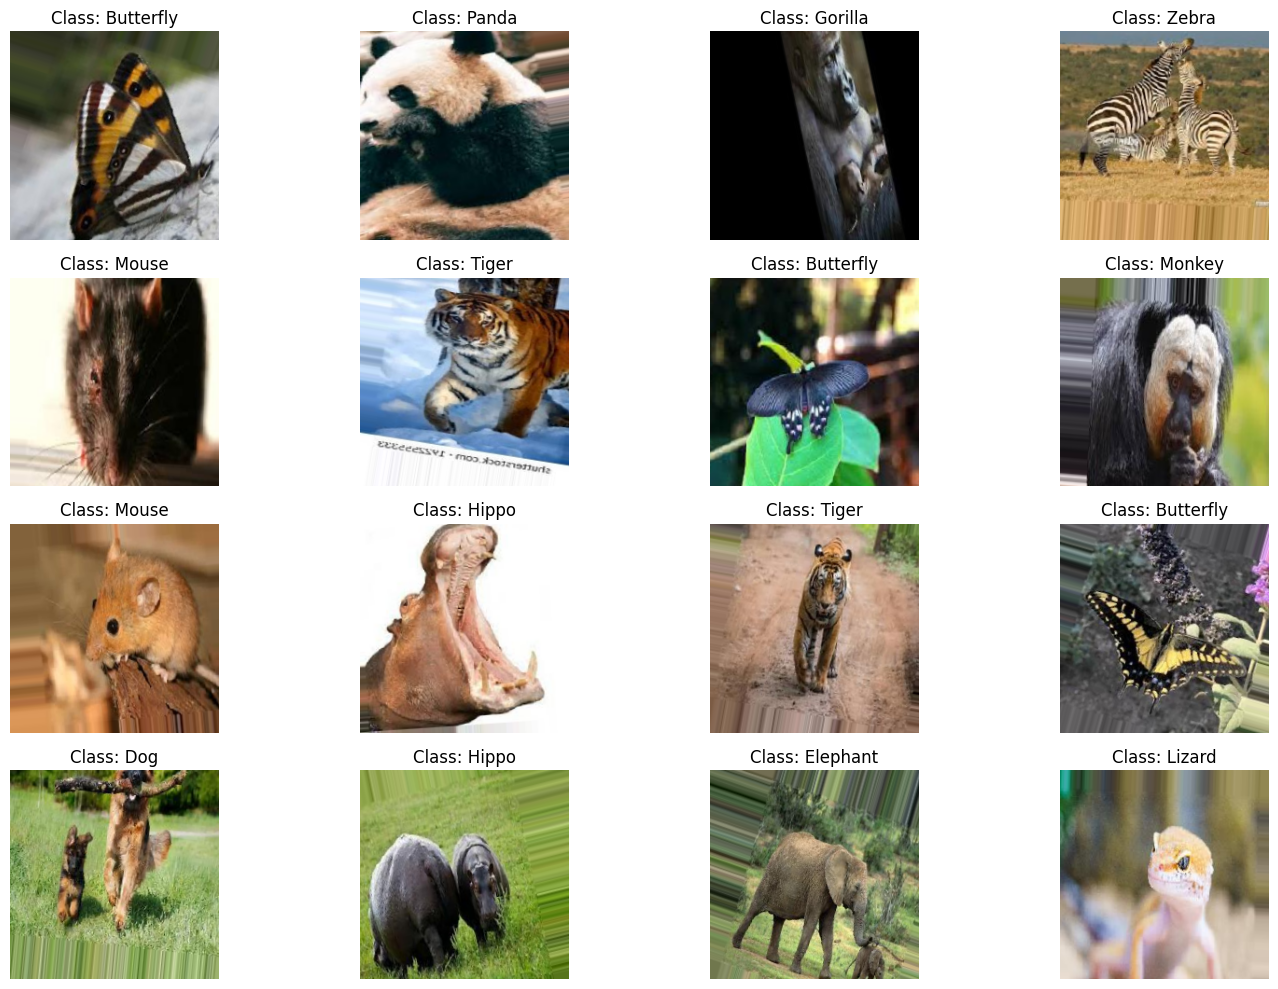

In [8]:
# Get samples from train data
images, labels = next(train_gen)
class_indices = np.argmax(labels, axis=1)

class_names = list(train_gen.class_indices.keys())

# Plot the images
plt.figure(figsize=(15, 10))
for i in range(min(batch_size, 16)): 
    plt.subplot(4, 4, i + 1) 
    plt.imshow(images[i])
    plt.title(f"Class: {class_names[class_indices[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# **Model**

In [9]:
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys()))

# Load EfficientNetB3 pre-trained on ImageNet
base_model = EfficientNetB3(
    weights='imagenet',
    include_top=False,
    input_shape=img_shape
)

model = Sequential([
    base_model,
    Flatten(),
    
    Dense(512,activation = "relu"),
    Dropout(0.3),
    Dense(256,activation = "relu"),
    Dense(class_count, activation = "softmax")
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 7, 7, 1536)          │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 75264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      38,535,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,454,398 (188.65 MB)

 Trainable params: 49,367,095 (188.32 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [10]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_gen, 
    epochs=20, 
    validation_data=valid_gen, 
    batch_size=batch_size,
    callbacks=[early_stopping]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


938/938 ━━━━━━━━━━━━━━━━━━━━ 695s 626ms/step - accuracy: 0.8315 - loss: 0.6530 - val_accuracy: 0.9515 - val_loss: 0.1872
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 335s 355ms/step - accuracy: 0.9439 - loss: 0.1980 - val_accuracy: 0.9605 - val_loss: 0.1595
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 329s 348ms/step - accuracy: 0.9606 - loss: 0.1476 - val_accuracy: 0.9590 - val_loss: 0.2140
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 330s 349ms/step - accuracy: 0.9614 - loss: 0.1360 - val_accuracy: 0.9645 - val_loss: 0.1798
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 332s 351ms/step - accuracy: 0.9699 - loss: 0.1190 - val_accuracy: 0.9600 - val_loss: 0.1917
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 329s 348ms/step - accuracy: 0.9735 - loss: 0.0991 - val_accuracy: 0.9645 - val_loss: 0.1925
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 329s 348ms/step - accuracy: 0.9785 - loss: 0.0849 - val_accuracy: 0.9655 - val_loss: 0.1596
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


# **Evaluate the Model**

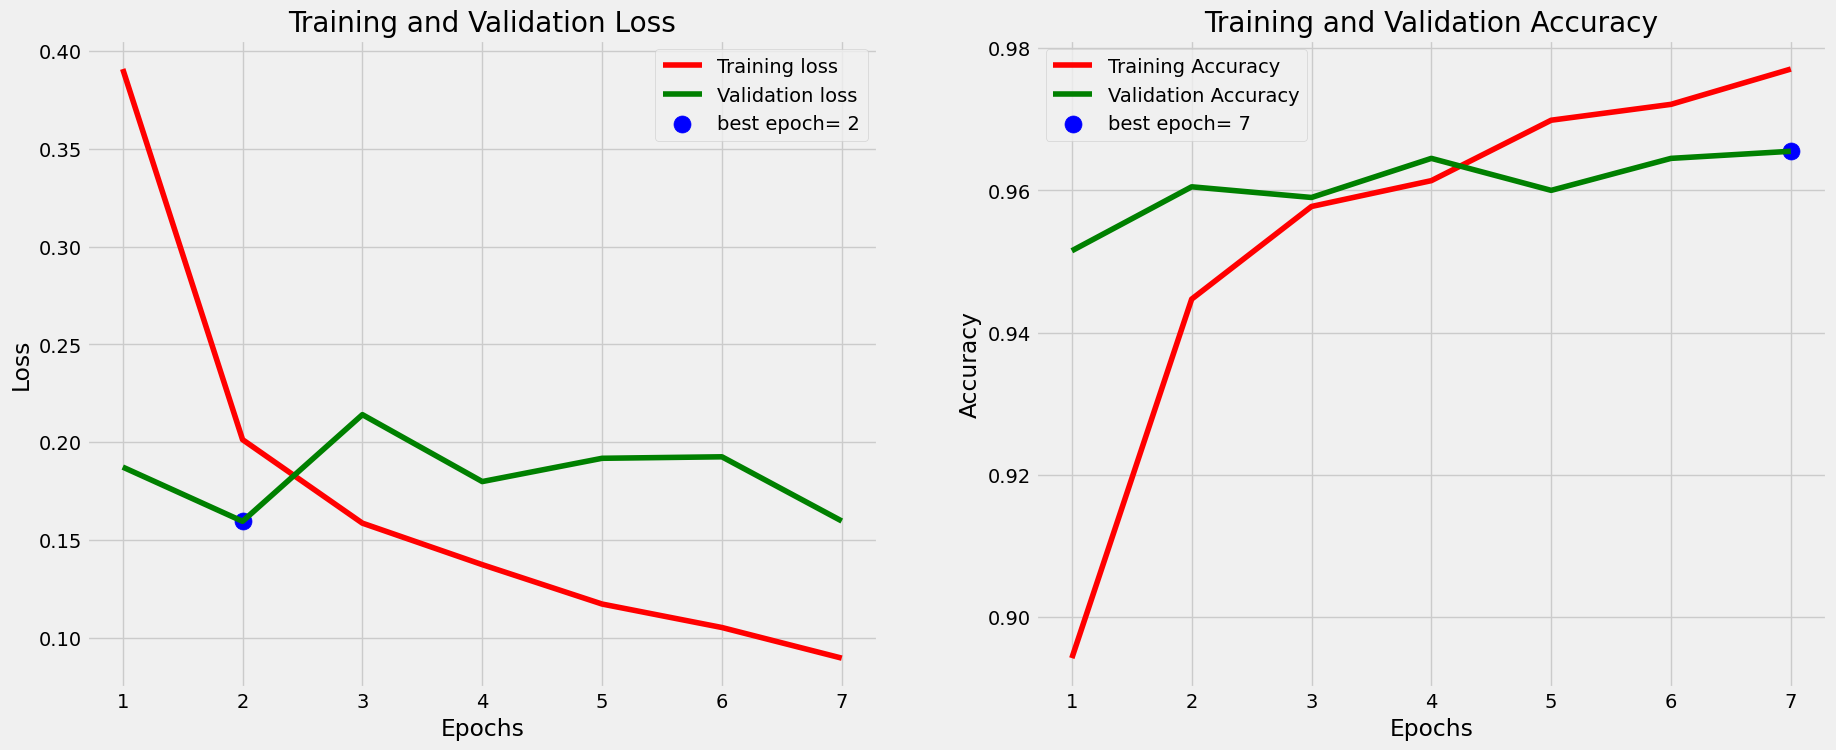

In [14]:
# Plot Accuracy and Loss
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [12]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

938/938 ━━━━━━━━━━━━━━━━━━━━ 320s 341ms/step - accuracy: 0.9790 - loss: 0.0771
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9630 - loss: 0.1367
 2/76 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.9531 - loss: 0.0907 

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


76/76 ━━━━━━━━━━━━━━━━━━━━ 28s 369ms/step - accuracy: 0.9259 - loss: 0.2795
Train Loss:  0.07505528628826141
Train Accuracy:  0.9791333079338074
--------------------
Validation Loss:  0.15946397185325623
Validation Accuracy:  0.9605000019073486
--------------------
Test Loss:  0.2204471230506897
Test Accuracy:  0.9430826902389526


In [15]:
# Get Predictions
preds = model.predict(test_gen) 
y_pred = np.argmax(preds, axis=1) 
g_dict = test_gen.class_indices 
classes = list(g_dict.keys())

76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 168ms/step


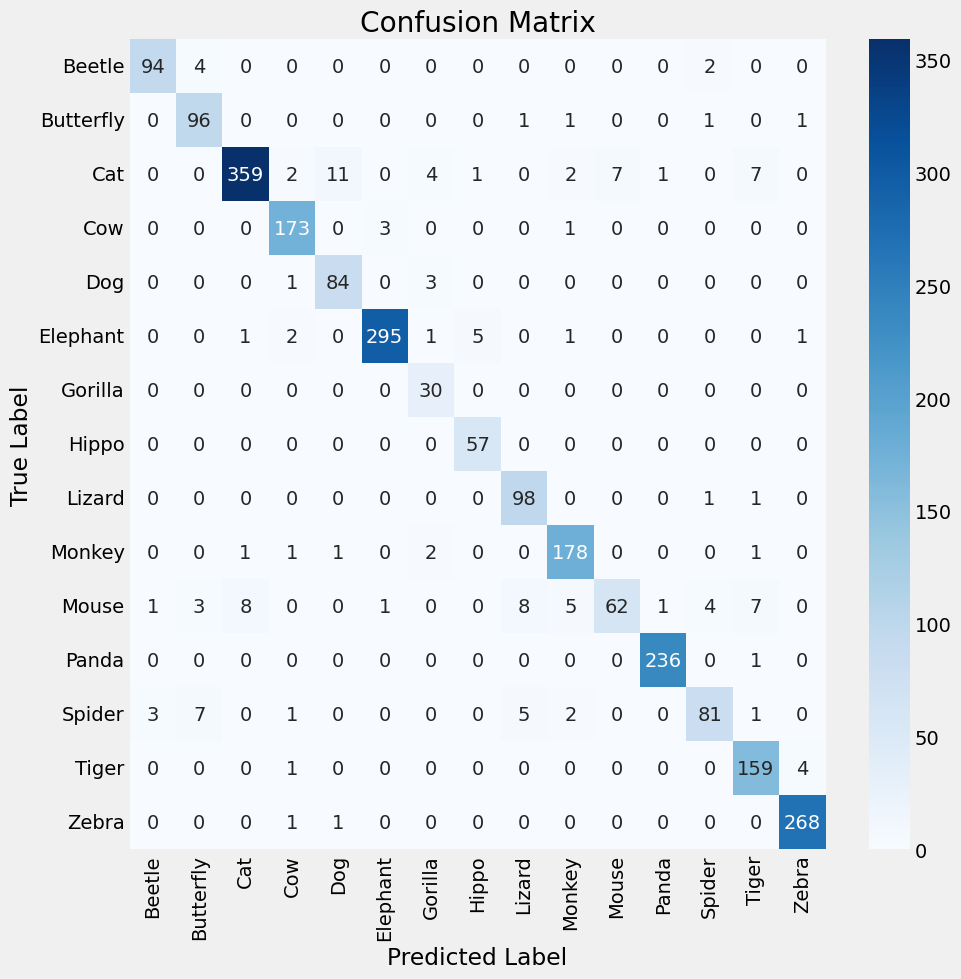

In [16]:
# Confusion Matrix
plt.figure(figsize=(10, 10))
cm = confusion_matrix(test_gen.classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [17]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      Beetle       0.96      0.94      0.95       100
   Butterfly       0.87      0.96      0.91       100
         Cat       0.97      0.91      0.94       394
         Cow       0.95      0.98      0.96       177
         Dog       0.87      0.95      0.91        88
    Elephant       0.99      0.96      0.98       306
     Gorilla       0.75      1.00      0.86        30
       Hippo       0.90      1.00      0.95        57
      Lizard       0.88      0.98      0.92       100
      Monkey       0.94      0.97      0.95       184
       Mouse       0.90      0.62      0.73       100
       Panda       0.99      1.00      0.99       237
      Spider       0.91      0.81      0.86       100
       Tiger       0.90      0.97      0.93       164
       Zebra       0.98      0.99      0.99       270

    accuracy                           0.94      2407
   macro avg       0.92      0.94      0.92      2407
weighted avg       0.94   

# **Save Model**

In [18]:
#Save the model
model.save('animal_species_classification.h5')